# Diabetes Risk Prediction

### 1. Diabetes mellitus

[Diabetes mellitus](https://en.wikipedia.org/wiki/Diabetes) is a disease characterized by high blood sugar levels over long periods. If left untreated, it can result in serious medical complications, such as cardiovascular disease, chronic kidney disease, and even death. 

### 2. Prevalence of Diabetes, and Devising a Solution
The prevalence of Diabetes in Singapore (10.5%) is not only higher than the world average (8.8%), but is also [ever increasing](https://www.healthhub.sg/a-z/diseases-and-conditions/626/diabetes). 

According to the World Health Organization (WHO), apart from prevention, [early diagnosis is one of the most effective ways](https://www.who.int/en/news-room/fact-sheets/detail/diabetes) to minimize the burden caused by diabetes. 

With this in mind, we are going to set out to construct a risk profile that measures an invidiual's susceptibility to the disease. The [dataset](https://www.kaggle.com/johndasilva/diabetes/downloads/diabetes.zip/1) we're going to work with was acquired from a hospital in Frankfurt, Germany. It contains a profile of health indicators such as BMI, Age, and Blood Glucose levels of individuals with and without Diabetes.

### 3. Capitalizing on the effectiveness of Early Diagnosis
Our objective here will be to train a predictive model using the available data to learn what the profile of a person afflicted with Diabetes looks like. This model will then receive the profile of an untested individual, and based on that person's health indicators, measure the similarity of their profile against that of a person with diabetes, and assign that person a value that represents their predicted risk of having Diabetes.

Our end-goal is to better educate individuals on their diabetes risk factor, so the disease can be diagnosed and tackled earlier. The predictive model will serve as a means to impart (possibly life-saving) health literacy to its users.

## Introduction

We'll begin by reading and briefly exploring the `diabetes.csv` dataset.

In [1]:
import numpy as np
import pandas as pd

diabetes = pd.read_csv('diabetes.csv')

print(diabetes.shape)
diabetes.head()

(2000, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [2]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
Pregnancies                 2000 non-null int64
Glucose                     2000 non-null int64
BloodPressure               2000 non-null int64
SkinThickness               2000 non-null int64
Insulin                     2000 non-null int64
BMI                         2000 non-null float64
DiabetesPedigreeFunction    2000 non-null float64
Age                         2000 non-null int64
Outcome                     2000 non-null int64
dtypes: float64(2), int64(7)
memory usage: 140.7 KB


We see that the dataset has 2000 rows and 9 columns.

Let's go through what the columns mean:

- Pregnancies - Number of Pregnancies the person has had.
- Glucose - Blood Sugar levels (mg/DL)
- BloodPressure - Measured Blood Pressure (mmHg)
- SkinThickness - Skin Thickness (mm).
- Insulin - Insulin Level
- BMI - A person's [Body Mass Index](https://en.wikipedia.org/wiki/Body_mass_index)
- DiabetesPedigreeFunction - Measures genetic influence (hereditary risk) of Diabetes
- Age - Age of the person
- Outcome - "1" represents a person with diabetes. "0" represents a healthy individual.

### Visualizing Distribution of the Data

Before proceeding with Data Cleaning, let's get a picture of values in all the above 9 columns are distributed.

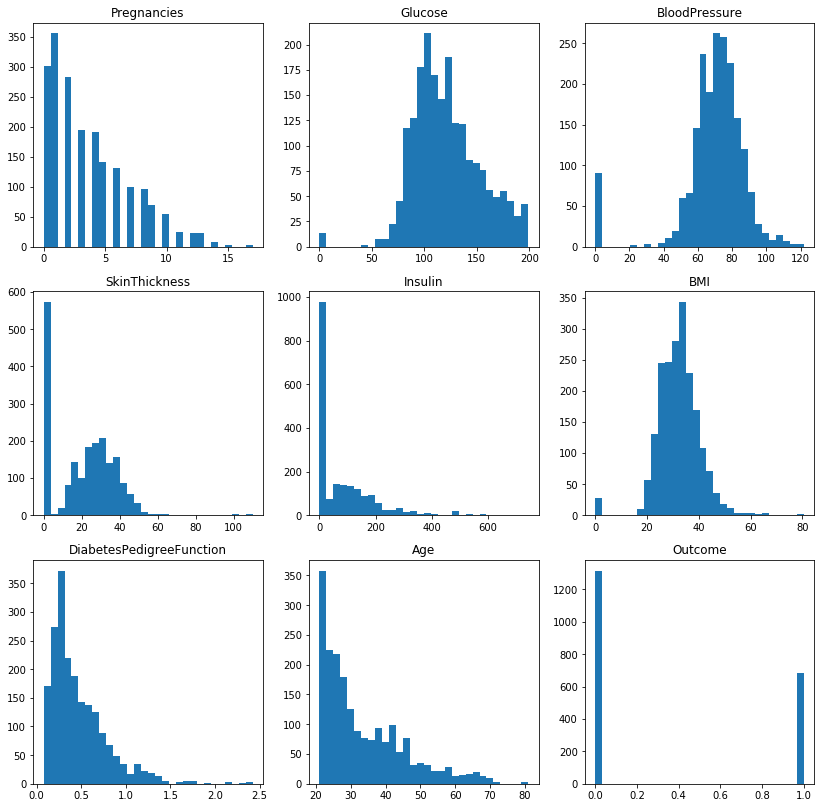

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt


# Making a list of col names:
cols = diabetes.columns.tolist()

fig = plt.figure(figsize=(14,14))
for position, col in enumerate(cols):
    ax = fig.add_subplot(3,3,position+1)
    ax.hist(diabetes[col], bins=30)
    plt.title(col)

plt.show()

Some columns, like `BMI` and `BloodPressure` look normally distributed.

One thing that stands out to us is that there are values in the `BMI`, `BloodPressure`, `Insulin`, and `SkinThickness` columns that are zero. 

Because realistically the values of these things could not possibly be 0 for a person, it likely means that the data in that row was either recorded incorrectly, or not recorded at all.

Let's also visualize the distribution of the data based on whether a person had diabetes.

### Visualizing distribution of Data based on Diabetes outcome

In [4]:
# Splitting dataframe

with_diabetes = diabetes[diabetes['Outcome'] == 1]
without_diabetes = diabetes[diabetes['Outcome'] == 0]

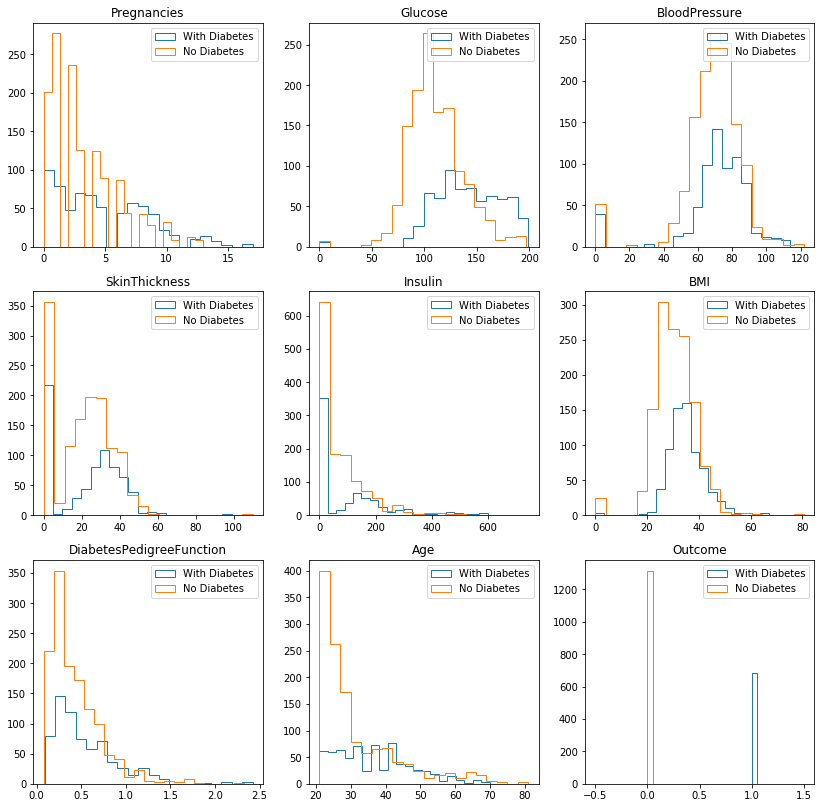

In [5]:
fig = plt.figure(figsize=(14,14))
for position, col in enumerate(cols):
    ax = fig.add_subplot(3,3,position+1)
    ax.hist(with_diabetes[col], histtype ='step', label='With Diabetes', bins = 20)
    ax.hist(without_diabetes[col], histtype ='step', label = 'No Diabetes', bins=20)
    ax.legend(loc=0)
    plt.title(col)

plt.show()

We notice that people with diabetes on average tend to be older, unsurprisingly have higher blood glucose levels, and also have more pregnancies on average which might simply be because of the correlation with age, since an older person is more likely to have had more pregnancies than a younger person.

## Data Processing

We want to clean the data to make it suitable to pass into a Machine Learning model. In particular, we should look out for the following things:
- Duplicate entries
- Incomplete Data (denoted by the several 0 values we saw above)
- Outlier Data, or data that is very obviously incorrect.

### Dropping Duplicate Rows
First, we'll drop any duplicate rows.

Because all the data we're working with is from the same hospital, it's extremely unlikely that two rows would be identical across every column. A better explanation would be that the data was incorrectly duplicated. We'll thus drop the duplicate columns.

In [6]:
diabetes = diabetes.drop_duplicates(keep='first')

diabetes.shape

(744, 9)

We see that dropping the duplicate columns dramatically reduced the size of the `diabetes` dataframe, from 2000 rows down to only 744.

### Handling incomplete Data

In some rows, there were 0 values for columns like `BMI`, `BloodPressure`, `Insulin`, and `Glucose`. We'll drop rows that still contain values of 0 in these columns.

In [7]:
diabetes = diabetes.drop(diabetes[diabetes['BMI']==0].index) 
diabetes = diabetes.drop(diabetes[diabetes['BloodPressure']==0].index) 
diabetes = diabetes.drop(diabetes[diabetes['Insulin']==0].index)
diabetes = diabetes.drop(diabetes[diabetes['Glucose']==0].index)
diabetes = diabetes.drop(diabetes[diabetes['SkinThickness']==0].index)

diabetes.shape

(381, 9)

Here, we see that we are further down to only 381 rows.

The main thing left to do at this point is selecting the features intelligently.

### Feature Selection

The `Pregnancies` column contains information on number of pregnancies, but while there is a correlation between diabetes likelihood and number of pregnancies, our data-set does not actually distinguish between males and females. If, for instance, a male is more likely to have diabetes based on other indicators, we don't want the prediction for him having diabetes being marked down just because his number of `Pregnancies` is 0. To avoid the problem of the predictive model being confounded by this, we will get rid of the `Pregnancies` column. 

There is also the fact that we have very limited understanding on how the `DiabetesPedigreeFunction` column's values are determined. This column measures an individual's hereditary predisposition to diabetes. Realistically, it is not going to be possible for an individual to input this measurement into our predictive model. We'll thus drop this column as well.

In [8]:
features = cols.copy()
features.remove('Outcome')
features.remove('DiabetesPedigreeFunction')
features.remove('Pregnancies')


print(features)

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']


At this junction, we are good to move on to training the model.

## Predictive Modelling - Logistic Regression

We'll first use Logistic Regression.

The error metric we'll be focusing on for now is accuracy (total correct predictions/total predictions).

We will assess its accuracy with KFold Cross Validation, to use our data with maximum efficiency.

In [9]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# Instantiate the model
weight = {
    1:1.05,
    0:1
}
log = LogisticRegression(class_weight = weight)

kf = KFold(n_splits=6) 
score = cross_val_score(log, diabetes[features], diabetes['Outcome'], cv=kf, scoring='accuracy')
print(score)
print("The mean accuracy is:",score.mean())

[0.75       0.6875     0.75       0.87301587 0.79365079 0.79365079]
The mean accuracy is: 0.7746362433862434


Using KFold cross validation with slightly more weight placed on a positive check for Diabetes, with 6 folds, we get an accuracy of around 77-78%.

We'll train this model on the entire data-set, and then enter in a custom values to see the probabilities of Diabetes assigned to us.

In [10]:
weight = {
    1:1.05,
    0:1
}

log_model = LogisticRegression(class_weight = weight)
log_model.fit(diabetes[features], diabetes['Outcome'])
log_model.predict_proba(np.array(diabetes[features].iloc[0]).reshape(1, -1))

array([[0.90168024, 0.09831976]])

In [11]:
diabetes[features].iloc[0]

Glucose           84.0
BloodPressure     82.0
SkinThickness     31.0
Insulin          125.0
BMI               38.2
Age               23.0
Name: 1, dtype: float64

In [12]:
testing1 = [120,10,100,190,50,60]
features

log_model.predict_proba(np.array(testing1).reshape(1, -1))[0,1]

0.951025775184868

In [13]:
features

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']

Now, we'll define a function receives inputs for the 6 feature columns, and then returns a Diabetes risk index.

In [39]:
def diabetes_risk_prediction(glucose, bp, skinthickness, insulin, bmi, age):
    indicator_list = [glucose, bp, skinthickness, insulin, bmi, age]
    predictions = log_model.predict_proba(np.array(indicator_list).reshape(1, -1))
    risk = predictions[0,1]
    print("-"*len("Health Indicator Analysis"))
    print("Health Indicator Analysis")
    print("-"*len("Health Indicator Analysis"))   
    if risk < 0.3:
        print("You are probably in good health, keep it up.")

        #print("-"*len("You are probably in good health, keep it up"))
    elif risk > 0.7:
        print("See a doctor as soon as you can and listen to their recommendations. You might be on the way to developing diabetes if you don't change your lifestyle.")
        
    elif risk > 0.9:
        print("Go to a hospital right away. Odds are high you have diabetes.")
    else:
        print("You should be alright for the most part, but take care not to let your health slip.")
    return print("Your Diabetes Risk Index is {:.2f}/50.".format(risk*0.5*100))
    
diabetes_risk_prediction(90,80,30,120,60,50)

-------------------------
Health Indicator Analysis
-------------------------
You are probably in good health, keep it up.
Your Diabetes Risk Index is 11.45/50.


We'll expand slightly on the function above. Now, it will not only receive all those inputs, but also re-instantiate the logistics regression and model and re-fit the data.

In [15]:
def diabetes_risk_prediction2(glucose, bp, skinthickness, insulin, bmi, age):
    weight = {
    1:1.05,
    0:1}

    log_model2 = LogisticRegression(class_weight = weight)
    log_model2.fit(diabetes[features], diabetes['Outcome'])
    
    indicator_list = [glucose, bp, skinthickness, insulin, bmi, age]
    predictions = log_model2.predict_proba(np.array(indicator_list).reshape(1, -1))
    risk = predictions[0,1]
    return risk

diabetes_risk_prediction2(100,80,30,120,30,45) #Test array.

0.2713386277845828

## Taking User Inputs and generating a Risk Index

In [38]:
while True:
    try:
        while True:
            Glucose = int(input("Enter your Blood Glucose Level (mg/DL):\n"))
            if Glucose > 0:
                    break
            else:
                print("Please enter a valid value")
        break
    except (ValueError, NameError):# if the input is invalid 
        print("Invalid input! Please choose again.") #prompts user to input valid action
        continue

while True:
    try:
        while True:
            BloodPressure = int(input("Enter your Blood Pressure (mmHg):\n"))
            if BloodPressure > 0:
                    break
            else:
                print("Please enter a valid value")
        break
    except (ValueError, NameError):# if the input is invalid 
        print("Invalid input! Please choose again.") #prompts user to input valid action
        continue
        
while True:
    try:
        while True:
            SkinThickness = int(input("Enter your Skin Thickness (mm):\n"))
            if SkinThickness > 0:
                    break
            else:
                print("Please enter a valid value")
        break
    except (ValueError, NameError):# if the input is invalid 
        print("Invalid input! Please choose again.") #prompts user to input valid action
        continue
        
while True:
    try:
        while True:
            Insulin = int(input("Enter your Insulin Level (mg/DL):\n"))
            if Insulin > 0:
                    break
            else:
                print("Please enter a valid value")
        break
    except (ValueError, NameError):# if the input is invalid 
        print("Invalid input! Please choose again.") #prompts user to input valid action
        continue
        

while True:
    try:
        while True:
            BMI = int(input("Enter your BMI:\n"))
            if BMI > 0:
                    break
            else:
                print("Please enter a valid value")
        break
    except (ValueError, NameError):# if the input is invalid 
        print("Invalid input! Please choose again.") #prompts user to input valid action
        continue    

while True:
    try:
        while True:
            Age = int(input("Enter your Age (Years):\n"))
            if Age > 0:
                    break
            else:
                print("Please enter a valid value")
        break
    except (ValueError, NameError):# if the input is invalid 
        print("Invalid input! Please choose again.") #prompts user to input valid action
        continue
        
diabetes_risk_prediction(Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age)

Enter your Blood Glucose Level (mg/DL):
100
Enter your Blood Pressure (mmHg):
60
Enter your Skin Thickness (mm):
20
Enter your Insulin Level (mg/DL):
130
Enter your BMI:
27
Enter your Age (Years):
25
Health Indicator Analysis
-------------------------
You are probably in good health, keep it up.
Your Diabetes Risk Index is 7.92/50.


### Future Work

Some future improvements to improve our predictive accuracy could be:
- Use an error metric other than accuracy score, like f1 score or precision.
- Use domain knowledge (acquired from a Doctor or more qualified person) to make better choices about feature engineering.
- Doing the prediction with algorithms like Neural Networks instead. 
- Using a larger data-set - ideally one from Singapore.